In [1]:
%load_ext autoreload
%autoreload 2

import sys
from google.colab import drive
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from keras.models import load_model

In [2]:
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
import utils

Mounted at /content/drive


In [3]:
# A fine-tuned model from betterModel.ipynb

model_name = "VGG16"
#model_name = "EfficientNetB0"
#model_name = "ResNet50"

model = load_model(f'/content/drive/MyDrive/CAFO_models/better{model_name}_step2.keras')

In [4]:
data_path = "/content/drive/MyDrive/CAFO_data/forTraining/"

datasets = ["tur", "ind", "tha", "per"]

gdf_list = []
for place in datasets:
  gdf = pd.read_pickle(f'{data_path}{place}_final.pkl')
  print(f"There are {len(gdf)} rows in the {place} dataset")
  gdf_list.append(gdf)

data = pd.concat(gdf_list).reset_index(drop=True)

There are 107 rows in the tur dataset
There are 143 rows in the ind dataset
There are 250 rows in the tha dataset
There are 244 rows in the per dataset


In [5]:
X = []
labels = []

for idx, row in data.iterrows():
  if row['Farm type'] == "Unknown CAFO":
    labels.append("CAFO")
    X.append(row["Sentinel"])
  elif row['Farm type'] == "Non-farm":
    labels.append("Non-farm")
    X.append(row["Sentinel"])
  else:
    print(f"Unexpected farm type, {row['Farm type']}")

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
y = to_categorical(encoded_labels, num_classes=len(set(labels)))

class_mapping = dict(zip(encoded_labels, labels))
print("Class mapping:", class_mapping)

meta = data.drop(columns=["Sentinel"])

Class mapping: {1: 'Non-farm', 0: 'CAFO'}


In [6]:
# Apply the model to all images

results = utils.get_predictions(model, X, y, model_name, data)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


In [7]:
turkey = results[results["Dataset name"] == "Turkey"]
india = results[results["Dataset name"] == "India"]
thailand = results[results["Dataset name"] == "Thailand"]
peru = results[results["Dataset name"] == "Peru"]

In [8]:
# Function for showing GradCAM heatmaps

def show_gradcam(df, prediction, label, layer, probability_range):
  X = [img['Sentinel'] for _, img in df.iterrows()]
  df.reset_index(inplace=True, drop=True)
  image, preprocessed_image = utils.select_test_image(X, model_name,\
                                                    df, prediction,\
                                                    label, probability_range)
  heatmap = utils.get_gradcam_heatmap(model, preprocessed_image,\
                                    last_conv_layer_name, prediction)
  utils.display_gradcam(image, heatmap, alpha=0.5)

# Turkey

In [9]:
# Generate sklearn classification report
print('\n', classification_report(turkey["Label"].to_list(), turkey['Model Class'].to_list()))

# Show some of the correctly- and incorrectly-classified images. Use the
# "ascending" kw to say whether the images should be arranged in order
# of ascending probability (True/False)

utils.plot_classified_images(X, turkey, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

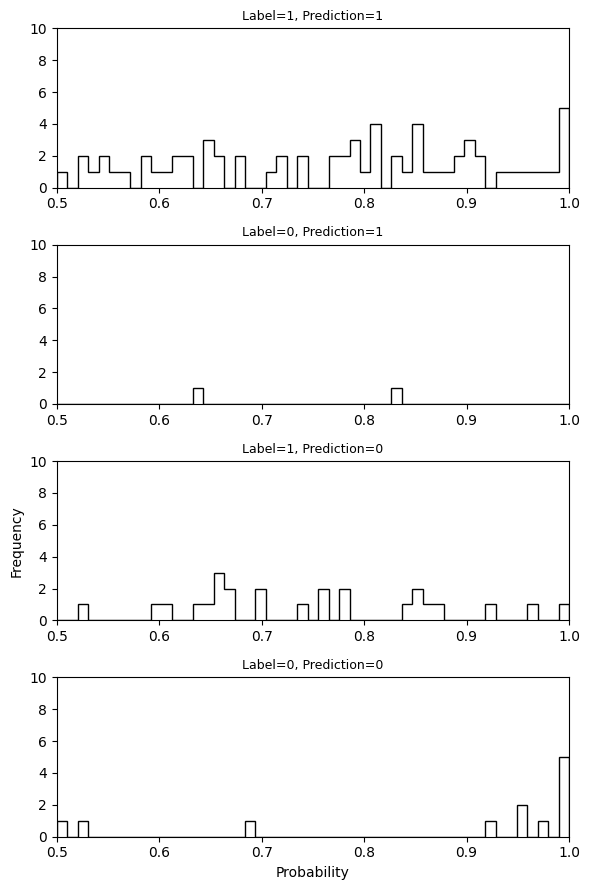

In [16]:
utils.probability_hist(turkey, datasets=["Turkey"], ymax=10)

Dataset: Turkey
Probability = 0.84


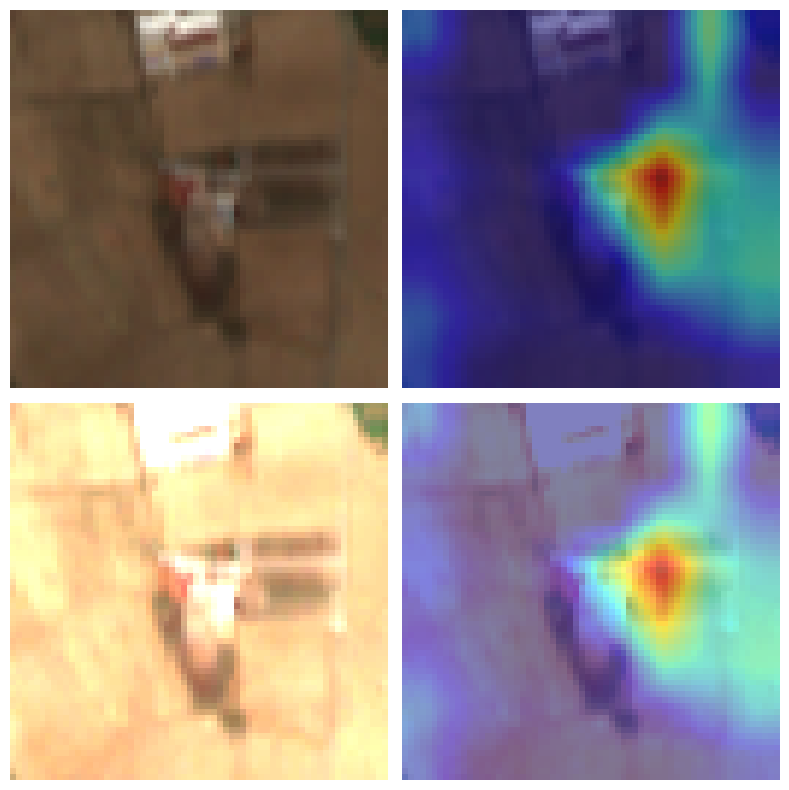

In [53]:
# Display GradCAM heatmaps

prediction = 0
label = 1
probability_range = (0.5, 1.0)
last_conv_layer_name = 'block4_conv3'

show_gradcam(turkey, prediction, label, last_conv_layer_name, probability_range)

# India

In [11]:
print('\n', classification_report(india["Label"].to_list(), india['Model Class'].to_list()))
utils.plot_classified_images(X, india, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

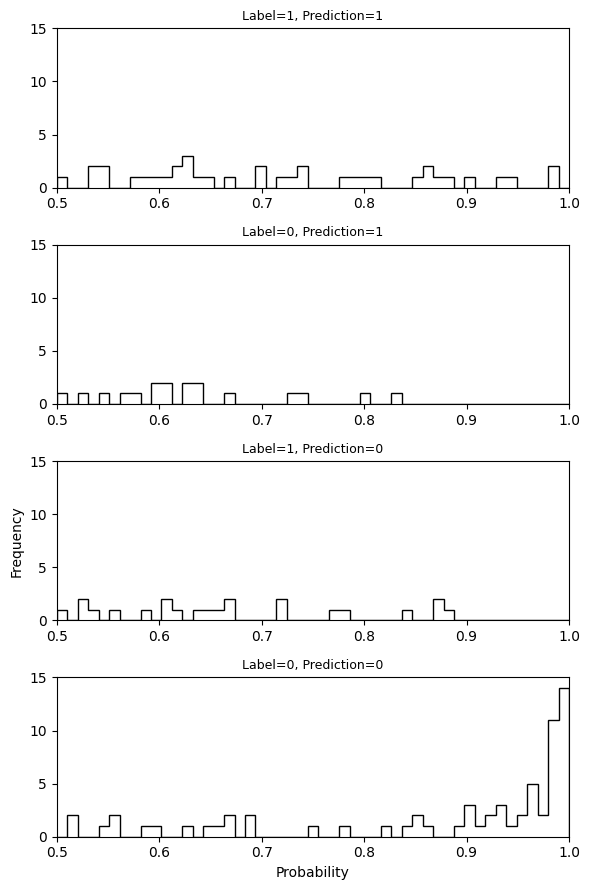

In [20]:
utils.probability_hist(india, datasets=["India"], ymax=15)

# Thailand

In [12]:
print('\n', classification_report(thailand["Label"].to_list(), thailand['Model Class'].to_list()))
utils.plot_classified_images(X, thailand, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

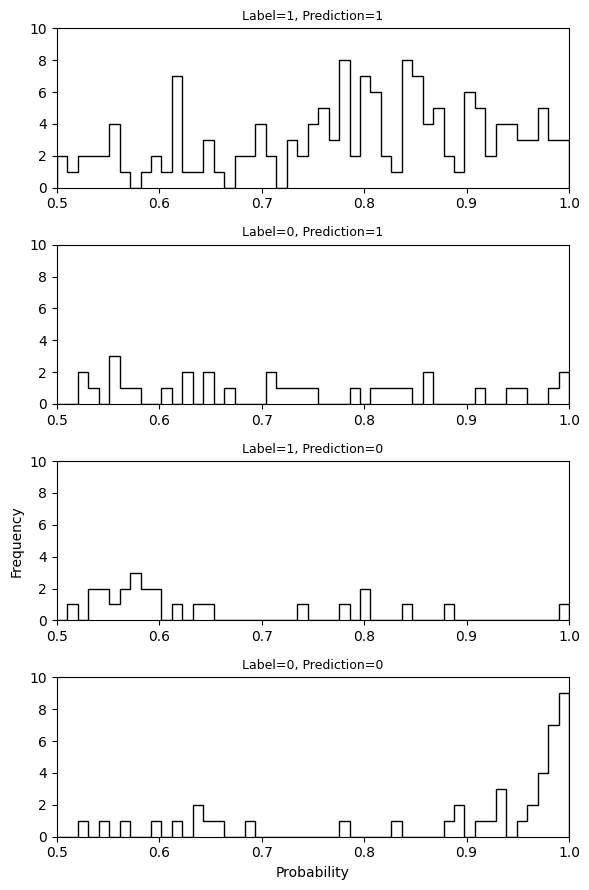

In [22]:
utils.probability_hist(thailand, datasets=["Thailand"], ymax=10)

# Peru

In [13]:
print('\n', classification_report(peru["Label"].to_list(), peru['Model Class'].to_list()))
utils.plot_classified_images(X, peru, class_mapping, ascending=False)

Output hidden; open in https://colab.research.google.com to view.

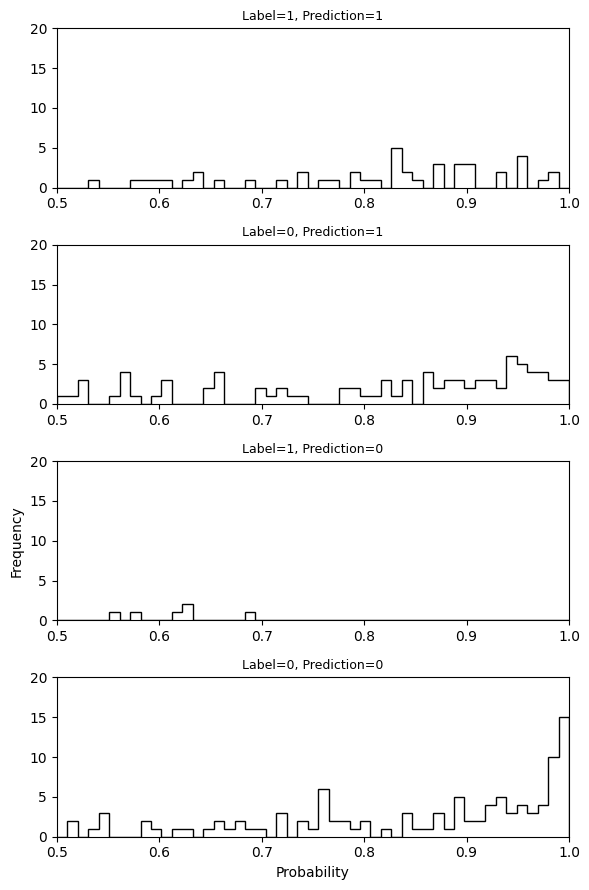

In [24]:
utils.probability_hist(peru, datasets=["Peru"], ymax=20)

Dataset: Peru
Probability = 0.99


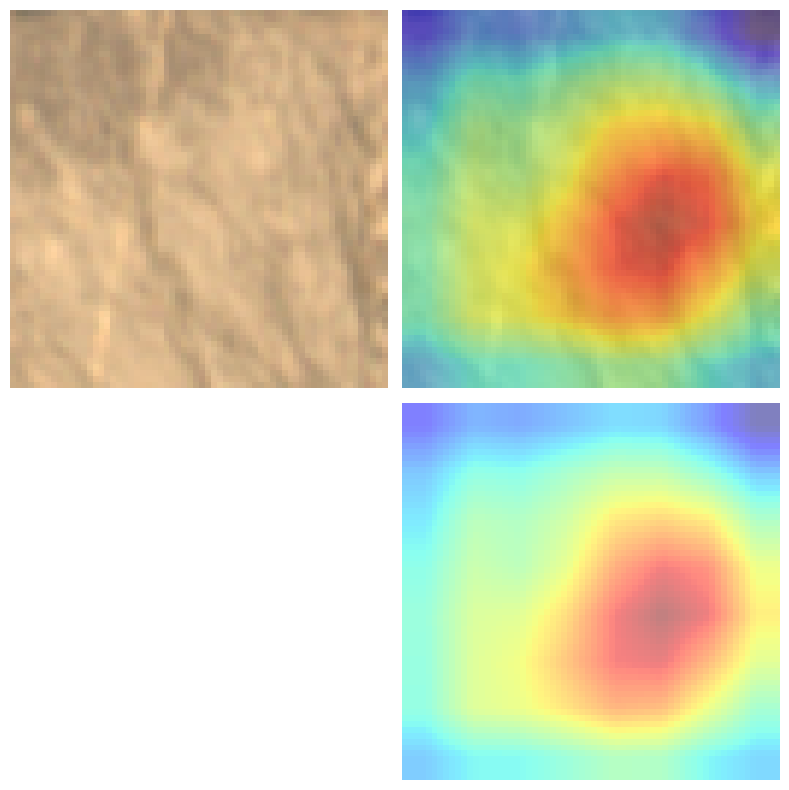

In [47]:
prediction = 1
label = 0
probability_range = (0.5, 1.0)
last_conv_layer_name = 'block4_conv3'

show_gradcam(peru, prediction, label, last_conv_layer_name, probability_range)